In [20]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy as cart
from datetime import datetime
import pandas as pd
import statsmodels.api as sm

In [2]:
import tqdm
from scipy.stats import linregress

In [3]:
input_dir = "/nethome/4302001/local_data/FREEBIORYS2V4/"
phys_dir = "/nethome/4302001/local_data/FREEGLORYS2V4/"

In [4]:
def open_dic(date, deptht=0, x_slice=slice(None), y_slice=slice(None)):
    file_name = f"freebiorys2v4-NorthAtlanticGoM-daily_dic_{date.year}-{date.month:02d}-{date.day:02d}.nc"
    ds = xr.open_dataset(input_dir + file_name)
    field = ds.dic.isel(deptht=deptht, x=x_slice, y=y_slice)
    return field

In [5]:
def open_salinity(date, deptht=0, x_slice=slice(None), y_slice=slice(None)):
    file_name = f"freeglorys2v4-NorthAtlanticGoM-daily_S_{date.year}-{date.month:02d}-{date.day:02d}.nc"
    ds = xr.open_dataset(phys_dir + file_name)
    field = ds.vosaline.isel(deptht=deptht, x=x_slice, y=y_slice)
    return field

In [10]:
# arange datetimes from 1995-01-01 to 2017-12-31, using monthly data (1st of each month)
start_date = pd.Timestamp("1995-01-01")
end_date = pd.Timestamp("2017-12-31")
dates = [start_date]
while dates[-1] < end_date:
    dates.append(dates[-1] + pd.DateOffset(days=7))

In [11]:
dic_fields = {date: open_dic(date, deptht=0, x_slice = slice(50, 300), y_slice=slice(40, 250)) for date in tqdm.tqdm(dates)}

100%|██████████| 1201/1201 [01:36<00:00, 12.39it/s]


In [12]:
salinities = {date: open_salinity(date, deptht=0, x_slice = slice(50, 300), y_slice=slice(40, 250)) for date in tqdm.tqdm(dates)}

100%|██████████| 1201/1201 [01:23<00:00, 14.40it/s]


In [13]:
n_fields = len(dic_fields)
print(f"Number of fields: {n_fields}")

Number of fields: 1201


In [14]:
lons = list(dic_fields.values())[0].nav_lon
lats = list(dic_fields.values())[0].nav_lat

In [15]:
dic_time = np.zeros((n_fields,) + list(dic_fields.values())[0].shape)
sal_time = np.zeros((n_fields,) + list(dic_fields.values())[0].shape)

In [16]:
for i in range(n_fields):
    dic_time[i, :, :] = list(dic_fields.values())[i].values
    sal_time[i, :, :] = list(salinities.values())[i].values

In [17]:
ndic_time = dic_time/sal_time * 36.6

In [18]:
x = np.arange(dic_time.shape[0])

In [19]:
dic_slopes = np.zeros(dic_time.shape[1:])
dic_r_values = np.zeros(dic_time.shape[1:])
dic_p_values = np.zeros(dic_time.shape[1:])

sal_slopes = np.zeros(dic_time.shape[1:])
sal_r_values = np.zeros(dic_time.shape[1:])
sal_p_values = np.zeros(dic_time.shape[1:])

ndic_slopes = np.zeros(ndic_time.shape[1:])
ndic_r_values = np.zeros(ndic_time.shape[1:])
ndic_p_values = np.zeros(ndic_time.shape[1:])

dic_salinity_correlation = np.zeros(dic_time.shape[1:])

In [24]:
def seasonally_detrended_linear_regression(x, y, period=52):
    if np.isnan(y).any():
        return np.nan, np.nan, np.nan, np.nan, np.nan
    
    decomposition = sm.tsa.seasonal_decompose(y, model='additive', period=period)
    trend = decomposition.trend
    slope, intercept, r_value, p_value, std_err = linregress(x[~np.isnan(trend)], trend[~np.isnan(trend)])
    return slope, intercept, r_value, p_value, std_err

In [25]:
for i in tqdm.tqdm(range(dic_time.shape[1])):
    for j in range(dic_time.shape[2]):
        slope, intercept, r_value, p_value, std_err = seasonally_detrended_linear_regression(x, dic_time[:, i, j])
        dic_slopes[i, j] = slope
        dic_r_values[i, j] = r_value ** 2
        dic_p_values[i, j] = p_value

        slope, intercept, r_value, p_value, std_err = seasonally_detrended_linear_regression(x, sal_time[:, i, j])
        sal_slopes[i, j] = slope
        sal_r_values[i, j] = r_value ** 2
        sal_p_values[i, j] = p_value

        slope, intercept, r_value, p_value, std_err = seasonally_detrended_linear_regression(x, ndic_time[:, i, j])
        ndic_slopes[i, j] = slope
        ndic_r_values[i, j] = r_value ** 2
        ndic_p_values[i, j] = p_value

        dic_salinity_correlation[i, j] = np.corrcoef(dic_time[:, i, j], sal_time[:, i, j])[0, 1]

100%|██████████| 210/210 [02:52<00:00,  1.22it/s]


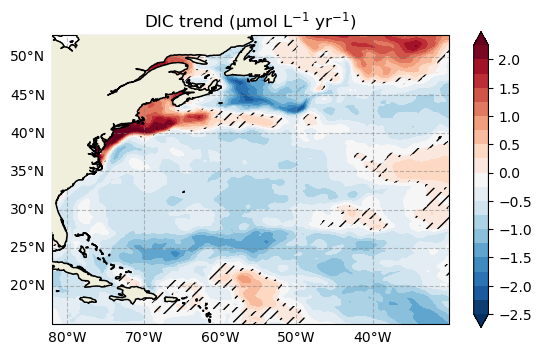

In [26]:
# plt.pcolormesh(lons, lats, slopes)
fig, ax = plt.subplots(subplot_kw={"projection": cart.crs.PlateCarree()})
trend = ax.contourf(lons, lats, dic_slopes / 7 * 365, levels = np.arange(-2.5, 2.5, 0.25), cmap = "RdBu_r", extend="both", zorder=1)

fig.colorbar(trend, shrink=0.8)
# stiple p-values < 0.05
ax.contourf(lons, lats, dic_p_values < 0.05, levels = [0, 0.5, 1], hatches=["///", ""], alpha=0, zorder=2)
# stiple r-values < 0.5
ax.add_feature(cart.feature.LAND, zorder=3, edgecolor="k")
ax.coastlines()
ax.set_extent([-82, -30, 15, 50])
ax.gridlines(draw_labels=["left", "bottom"], linestyle="--", alpha=0.5, color='gray')
ax.set_title("DIC trend (µmol L$^{-1}$ yr$^{-1}$)")
plt.show()


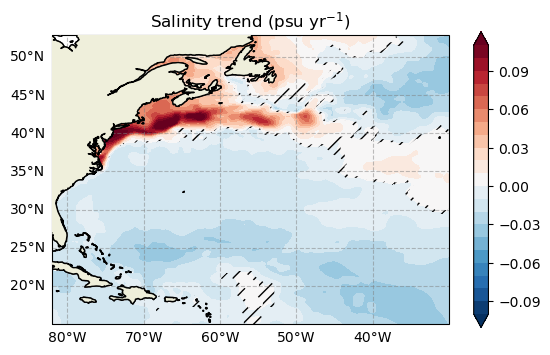

In [27]:
# plt.pcolormesh(lons, lats, slopes)
fig, ax = plt.subplots(subplot_kw={"projection": cart.crs.PlateCarree()})
trend = ax.contourf(lons, lats, sal_slopes / 7 * 365, levels = np.arange(-0.1, 0.12, 0.01), cmap = "RdBu_r", extend="both", zorder=1)

fig.colorbar(trend, shrink=0.8)
# stiple p-values < 0.05
ax.contourf(lons, lats, sal_p_values < 0.05, levels = [0, 0.5, 1], hatches=["///", ""], alpha=0, zorder=2)
# stiple r-values < 0.5
ax.add_feature(cart.feature.LAND, zorder=3, edgecolor="k")
ax.coastlines()
ax.set_extent([-82, -30, 15, 50])
ax.gridlines(draw_labels=["left", "bottom"], linestyle="--", alpha=0.5, color='gray')
ax.set_title("Salinity trend (psu yr$^{-1}$)")
plt.show()


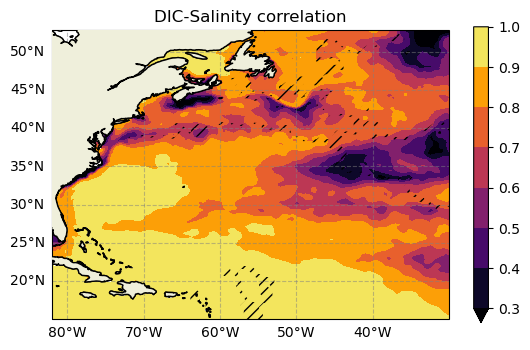

In [28]:
# plt.pcolormesh(lons, lats, slopes)
fig, ax = plt.subplots(subplot_kw={"projection": cart.crs.PlateCarree()})
salinity_corr = ax.contourf(lons, lats, dic_salinity_correlation, levels = np.arange(0.3, 1.01, 0.1), extend="min", cmap = "inferno")
fig.colorbar(salinity_corr, shrink=0.8)
# stiple p-values < 0.05
ax.contourf(lons, lats, sal_p_values < 0.05, levels = [0, 0.5, 1], hatches=["///", ""], alpha=0, zorder=2)
# stiple r-values < 0.5
ax.add_feature(cart.feature.LAND, zorder=3, edgecolor="k")
ax.coastlines()
ax.set_extent([-82, -30, 15, 50])
ax.gridlines(draw_labels=["left", "bottom"], linestyle="--", alpha=0.5, color='gray')
ax.set_title("DIC-Salinity correlation")
plt.show()


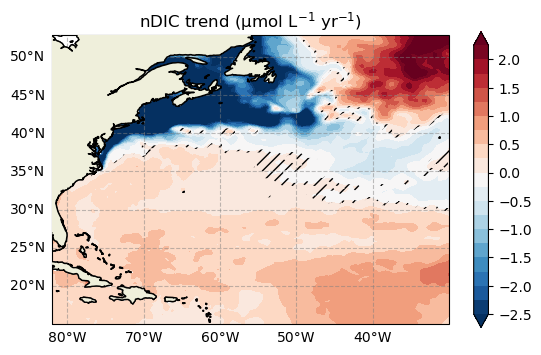

In [29]:
# plt.pcolormesh(lons, lats, slopes)
fig, ax = plt.subplots(subplot_kw={"projection": cart.crs.PlateCarree()})
trend = ax.contourf(lons, lats, ndic_slopes / 7 * 365, levels = np.arange(-2.5, 2.5, 0.25), cmap = "RdBu_r", extend="both", zorder=1)

fig.colorbar(trend, shrink=0.8)
# stiple p-values < 0.05
ax.contourf(lons, lats, ndic_p_values < 0.05, levels = [0, 0.5, 1], hatches=["///", ""], alpha=0, zorder=2)
# stiple r-values < 0.5
ax.add_feature(cart.feature.LAND, zorder=3, edgecolor="k")
ax.coastlines()
ax.set_extent([-82, -30, 15, 50])
ax.gridlines(draw_labels=["left", "bottom"], linestyle="--", alpha=0.5, color='gray')
ax.set_title("nDIC trend (µmol L$^{-1}$ yr$^{-1}$)")
plt.show()


In [53]:
ds_DIC_record = xr.open_dataset("output/DIC_EDW_record.nc").isel(time=slice(365*3 + 1, -365*3+31))

/tmp/ipykernel_5513/401479399.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


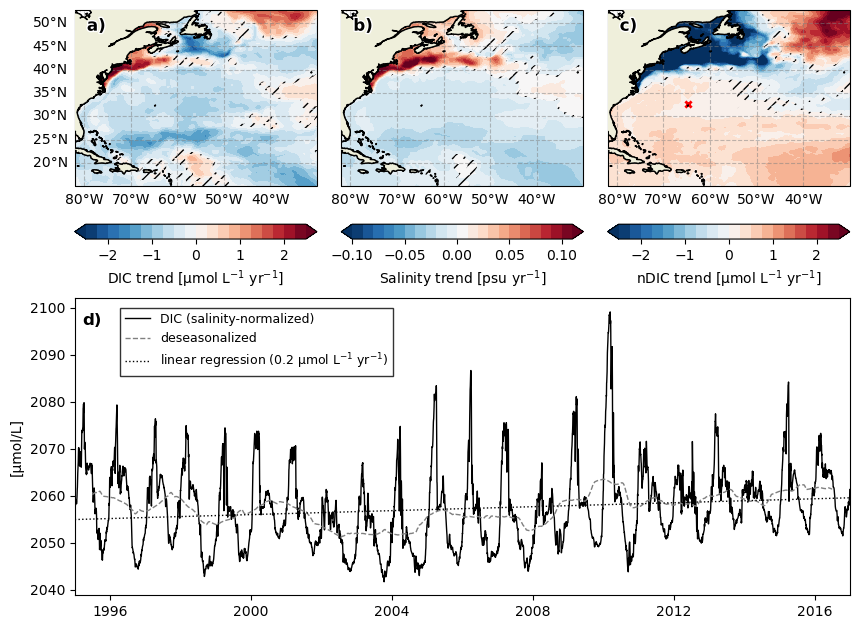

In [88]:
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(4, 3, width_ratios=[1, 1, 1], height_ratios=[0.8, 0.05, 0.15, 1], wspace=0.1, hspace=0.05)


ax1 = fig.add_subplot(gs[0, 0], projection=cart.crs.PlateCarree())
trend_dic = ax1.contourf(lons, lats, dic_slopes / 7 * 365, levels = np.arange(-2.5, 2.75, 0.25), cmap = "RdBu_r", extend="both", zorder=1)
cbar_ax1 = fig.add_subplot(gs[1,0])
cbar1 = plt.colorbar(trend_dic, shrink=0.3, orientation='horizontal', cax=cbar_ax1, label="DIC trend [µmol L$^{-1}$ yr$^{-1}$]", ticks=[-2, -1, 0, 1, 2])
ax1.contourf(lons, lats, dic_p_values < 0.05, levels = [0, 0.5, 1], hatches=["///", ""], alpha=0, zorder=2)


ax2 = fig.add_subplot(gs[0, 1], projection=cart.crs.PlateCarree())
trend_sal = ax2.contourf(lons, lats, sal_slopes / 7 * 365, levels = np.arange(-0.1, 0.12, 0.01), cmap = "RdBu_r", extend="both", zorder=1)
cbar_ax2 = fig.add_subplot(gs[1,1])
cbar2 = plt.colorbar(trend_sal, orientation='horizontal', cax=cbar_ax2, label="Salinity trend [psu yr$^{-1}$]", ticks=[-0.1, -0.05, 0, 0.05, 0.1]) 
ax2.contourf(lons, lats, sal_p_values < 0.05, levels = [0, 0.5, 1], hatches=["///", ""], alpha=0, zorder=2)

ax3 = fig.add_subplot(gs[0, 2], projection=cart.crs.PlateCarree())
trend_ndic = ax3.contourf(lons, lats, ndic_slopes / 7 * 365, levels = np.arange(-2.5, 2.75, 0.25), cmap = "RdBu_r", extend="both", zorder=1)
cbar_ax3 = fig.add_subplot(gs[1,2])
ax3.contourf(lons, lats, ndic_p_values < 0.05, levels = [0, 0.5, 1], hatches=["///", ""], alpha=0, zorder=2)
cbar3 = plt.colorbar(trend_ndic, orientation='horizontal', cax=cbar_ax3, label="nDIC trend [µmol L$^{-1}$ yr$^{-1}$]", ticks=[-2, -1, 0, 1, 2]) 

import matplotlib.patheffects as pe
for axi, ax in enumerate([ax1, ax2, ax3]):
    ax.add_feature(cart.feature.LAND, zorder=3, edgecolor="k")
    ax.coastlines()
    ax.set_extent([-82, -30, 15, 50])
    deg_labels = ["bottom"]
    if axi == 0:
        deg_labels.append("left")
    ax.gridlines(draw_labels=deg_labels, linestyle="--", alpha=0.5, color='gray')
    ax.text(0.05, 0.95, f"{chr(ord('a') + axi)})", transform=ax.transAxes, zorder=20, fontsize=12, color='black', fontweight='bold',path_effects=[pe.withStroke(linewidth=2, foreground='white')], va='top')
    ax.set_zorder(100)




ax3.scatter([-64.774], [32.698], marker='x', color='red', s=20, linewidth=2)

ax_dummy = fig.add_subplot(gs[2, :])
ax_dummy.axis('off')

ax_record = fig.add_subplot(gs[3, :])
record = (ds_DIC_record.DIC_station_1 / ds_DIC_record.S_station_1 * 36).sel(deptht=10, method='nearest')
ax_record.plot(record.time, record, color='black', linewidth=1, label="DIC (salinity-normalized)")

x = np.arange(0, len(record))
y = record.values

decomposition = sm.tsa.seasonal_decompose(y, model='additive', period=365)
trend = decomposition.trend
slope, intercept, r_value, p_value, std_err = linregress(x[~np.isnan(trend)], trend[~np.isnan(trend)])

ax_record.plot(record.time, trend, color='grey', label='deseasonalized', linestyle='--', linewidth=1)
ax_record.plot(record.time, intercept + slope*x, color='black', linestyle=':', linewidth=1, label=f"linear regression ({(slope *365):.1} "+r"µmol L$^{-1}$ yr$^{-1}$)")
ax_record.set_xlim(record.time[0], record.time[-1])
ax_record.set_ylabel("[µmol/L]")
ax_record.legend(fancybox=False, edgecolor='black', fontsize=9, loc='upper left', bbox_to_anchor=(0.05, 0.99))
ax_record.text(0.01, 0.95, f"d)", transform=ax_record.transAxes, zorder=20, fontsize=12, color='black', fontweight='bold', va='top')

plt.tight_layout()
plt.savefig("figures/nDIC_trends.png", dpi=450, bbox_inches="tight")


plt.show()